# Chapter 8 Applied Exercises: Tree-based methods

### 7. In Section 8.3.3, we applied random forests to the Boston data using max_features = 6 and using n_estimators = 100 and n_estimators = 500. Create a plot displaying the test error resulting from random forests on this data set for a more comprehensive range of values for max_features and n_estimators. You can model your plot after Figure 8.10. Describe the results obtained.

In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from patsy import dmatrices
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import graphviz 
from sklearn import tree

import warnings
warnings.filterwarnings('ignore')

In [41]:
# Load data
df = pd.read_csv('..\Data sets\Boston.csv')

# Create a copy of the data frame
df_copy = df

df = df.drop(columns='Unnamed: 0')

df

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,6.48,22.0


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [43]:
# Set up design matrices and formulas
f = 'medv ~ + ' + ' + '.join(df.drop(columns='medv'))

# Set up design matrices
y, X = dmatrices(f, df, return_type='dataframe')

# Split into a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

<Axes: xlabel='Number of trees', ylabel='Root mean squared error'>

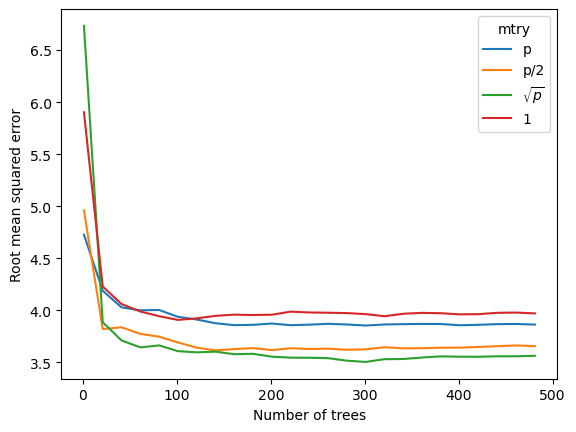

In [44]:
# Fit random forest with varying number of trees and predictors.
max_features = {'p' : X.shape[1],
                'p/2' : int(np.round(X.shape[1]/2,0)),
                '$\sqrt{p}$' : int(np.round(np.sqrt(X.shape[1]))),
                '1' : 1}

results = []
for mtry in max_features:
    for tree_count in np.arange(1,500, 20):
        RF = RandomForestRegressor(max_features=max_features[mtry], random_state=0, n_estimators=tree_count)
        RF.fit(X_train, y_train)
        y_pred = RF.predict(X_test)

        mse = metrics.mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        results += [[tree_count, mtry, rmse]]

fig, ax = plt.subplots()
sns.lineplot(x='Number of trees', y = 'Root mean squared error', hue='mtry', data=pd.DataFrame(results, columns = ['Number of trees', 'mtry', 'Root mean squared error']))

The root mean squared error decreased as the number of trees increase. The best number of features tested above is $\sqrt{p}$. The best value is more than one but less than p. 

Why does the root mean squared error not increase as the number of trees increase? I guess this is due to the random forest randomly sampling the features. 

### 8. In the lab, a classification tree was applied to the Carseats data set after converting Sales into a qualitative response variable. Now we will seek to predict Sales using regression trees and related approaches, treating the response as a quantitative variable.

#### (a) Split the data set into a training set and a test set.

In [45]:
# Load data
df = pd.read_csv('..\Data sets\Carseats.csv')

df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes


In [46]:
# Define features and response variables
X = df.drop(columns='Sales')
y = df['Sales']

# Design formula
f = 'Sales ~ 0 + ' + ' + '.join(X.columns)

# Set up desig matrices
y, X = dmatrices(f, df, return_type='dataframe')

# Split into a train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)
y_train

,Sales
157,10.21
109,8.98
17,12.29
347,6.88
24,10.14
...,...
71,6.50
106,0.16
270,11.99
348,12.57


#### (b) Fit a regression tree to the training set. Plot the tree, and interpret the results. What test MSE do you obtain?

In [47]:
# Fit the decision tree
DT = tree.DecisionTreeRegressor(max_depth=5).fit(X_train, y_train)

# Make predictions
y_pred = DT.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)

print('Test MSE: {}'.format(round(mse,2)))
print('Test RMSE: {}'.format(round(np.sqrt(mse),2)))

Test MSE: 4.74
Test RMSE: 2.18


#### Plot the tree.

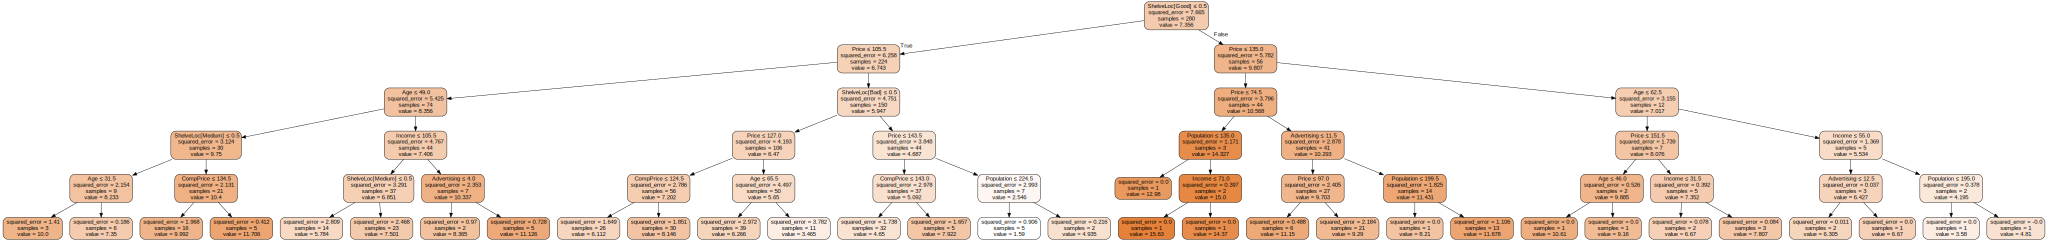

In [48]:
dot_data = tree.export_graphviz(DT, out_file=None, 
                     feature_names=X.columns,  
                     filled=True, rounded=True,  
                     special_characters=True)  
graph = graphviz.Source(dot_data)  
graph

#### (c) Use cross-validation in order to determine the optimal level of tree complexity. Does pruning the tree improve the test MSE?

In [49]:
cv_folds = 10
tuning_param = 'max_leaf_nodes'
columns = [tuning_param, 'RMSE', 'upper', 'lower']

results = []
for m in np.arange(2,100):
    regr = tree.DecisionTreeRegressor(max_leaf_nodes=m)
    scores = cross_val_score(regr, X_train, y_train, cv=cv_folds, scoring='neg_mean_squared_error')
    rmses = np.sqrt(np.absolute(scores))
    rmse = np.mean(rmses)
    conf_int = np.std(rmses)*2
    results += [[m, rmse, rmse+conf_int, rmse-conf_int]]

results_df = pd.DataFrame(results, columns=columns).set_index(tuning_param)

Text(0, 0.5, 'RMSE')

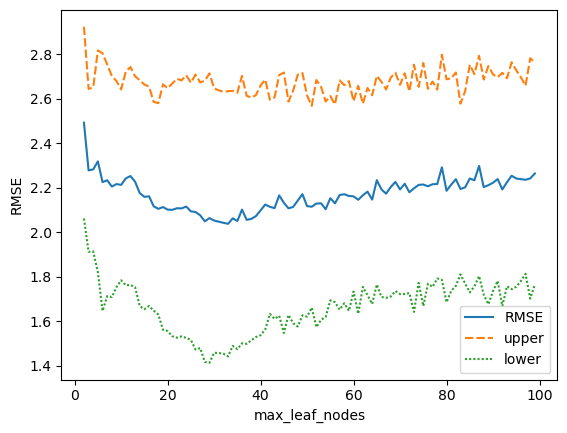

In [50]:
# Plot the results
fig, ax = plt.subplots()
sns.lineplot(data=results_df)
ax.set_ylabel('RMSE')

In [51]:
results_df[results_df['RMSE'] == results_df['RMSE'].min()]

,RMSE,upper,lower
max_leaf_nodes,,,
33,2.03834,2.634586,1.442094


The original RMSE is 2.2 versus a RMSE of 2.03 when the tree is pruned.

#### (d) Use the bagging approach in order to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important.

In [52]:
# Define parameters
max_features = X.shape[1]
tree_count = 100

# Fit the model
RF = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
RF.fit(X_train, y_train)

# Make predictions
y_pred = RF.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test MSE: {}'.format(round(mse,2)))
print('Test RMSE: {}'.format(round(np.sqrt(mse),2)))

Test MSE: 2.54
Test RMSE: 1.6


**Note** Bagging is the same as random forest if m=p. Therefore it is fine to use RandomForestRegressor here. 

<Axes: xlabel='Importance', ylabel='Feature'>

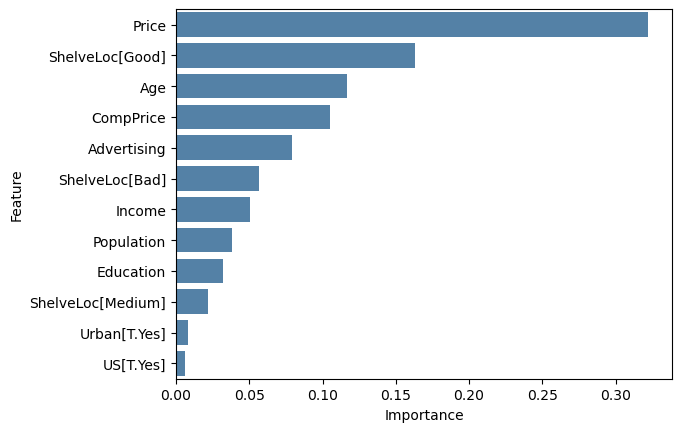

In [53]:
# Create a dataframe of the results
results = pd.DataFrame({'Feature':X.design_info.column_names, 'Importance' : RF.feature_importances_})

# Plot the results
fig, ax = plt.subplots()
sns.barplot(x='Importance', y='Feature', data=results.sort_values('Importance', ascending=False),color='steelblue')

#### (e) Use random forests to analyze this data. What test MSE do you obtain? Use the feature_importance_ values to determine which variables are most important. Describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In [59]:
# Define parameters
tree_count = 100
max_features = 7

# Fit the model
RF = RandomForestRegressor(max_features=max_features, random_state=0, n_estimators=tree_count)
RF.fit(X_train, y_train)

# Make predictions
y_pred = RF.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test MSE: {}'.format(round(mse,2)))
print('Test RMSE: {}'.format(round(np.sqrt(mse),2)))

Test MSE: 2.62
Test RMSE: 1.62


**Note** Random forest with $m = \sqrt{p}$.

<Axes: xlabel='Importance', ylabel='Feature'>

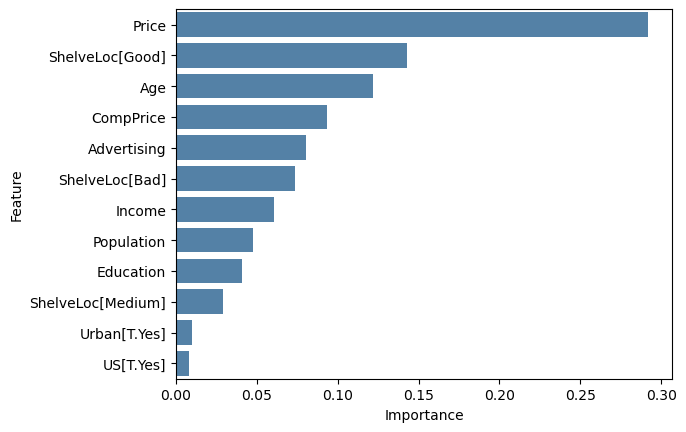

In [60]:
# Create a dataframe of the results
results = pd.DataFrame({'Feature':X.design_info.column_names, 'Importance' : RF.feature_importances_})

# Plot the results
fig, ax = plt.subplots()
sns.barplot(x='Importance', y='Feature', data=results.sort_values('Importance', ascending=False),color='steelblue')

In [63]:
# Define parameters
tree_count = 100

results = []
for m in np.arange(1, X.shape[1]):

    # Fit the model
    RF = RandomForestRegressor(max_features=m, random_state=0, n_estimators=tree_count)
    RF.fit(X_train, y_train)

    # Make predictions
    y_pred = RF.predict(X_test)

    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    results += [[m, mse, rmse]]

<Axes: xlabel='Features', ylabel='MSE'>

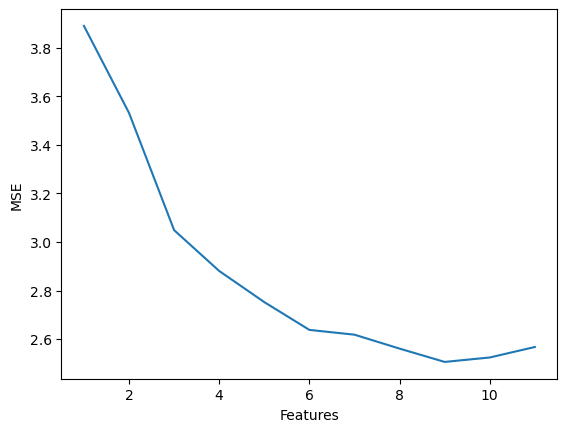

In [67]:
# Plot the results
fig, ax = plt.subplots()
sns.lineplot(x='Features', y='MSE', data=pd.DataFrame(results, columns=['Features', 'MSE', 'RMSE']))